In [64]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

In [65]:
class Encoder(Model):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.convolution_01 = tf.keras.layers.Conv2D(
            32, (3, 3), strides=2, activation="relu", padding="same"
        )
        self.convolution_02 = tf.keras.layers.Conv2D(
            64, (3, 3), strides=2, activation="relu", padding="same"
        )
        self.flatten = tf.keras.layers.Flatten()
        self.fully_connected_01 = tf.keras.layers.Dense(units=128, activation="relu")
        self.mean_of_latent_distribution = tf.keras.layers.Dense(units=self.latent_dimension)
        self.log_variance_of_latent = tf.keras.layers.Dense(units=self.latent_dimension)
        
    def call(self, X):
        X = self.convolution_01(X)
        X = self.convolution_02(X)
        X = self.flatten(X)
        X = self.fully_connected_01(X)
        z_mean_of_latent_distribution = self.mean_of_latent_distribution(X)
        z_log_variance_of_latent = self.log_variance_of_latent(X)
        return z_mean_of_latent_distribution, z_log_variance_of_latent


In [66]:
class Decoder(Model):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.fully_connected = tf.keras.layers.Dense(
            units=7 * 7 * 64, activation="relu"
        )
        self.reshape = tf.keras.layers.Reshape((7, 7, 64))
        self.deconvolution_01 = tf.keras.layers.Conv2DTranspose(
            64, (3, 3), strides=2, activation="relu", padding="same"
        )
        self.deconvolution_02 = tf.keras.layers.Conv2DTranspose(
            32, (3, 3), strides=2, activation="relu", padding="same"
        )
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            1, (3, 3), activation="sigmoid", padding="same"
        )
        
    def call(self, z):
        X = self.fully_connected(z)
        X = self.reshape(X)
        X = self.deconvolution_01(X)
        X = self.deconvolution_02(X)
        X = self.output_layer(X)
        return X

In [67]:
# Sampling latent space
def sample_latent(z_mean_of_latent_distribution, z_log_variance_of_latent):
    batch = tf.shape(z_mean_of_latent_distribution)[0]
    dimension = tf.shape(z_mean_of_latent_distribution)[1]
    epsilon = tf.random.normal(shape=(batch, dimension))
    result = z_mean_of_latent_distribution + tf.exp(0.5 * z_log_variance_of_latent) * epsilon
    return result

# Loss function
def vae_loss(X, X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(X, X_reconstructed), axis=(1, 2)
    ))
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
        1 + z_log_variance_of_latent - tf.square(z_mean_of_latent_distribution) - tf.exp(z_log_variance_of_latent), axis=1
    ))
    return reconstruction_loss + kl_loss

In [68]:
class VariationalAutoEncoder(Model):
    def __init__(self, latent_dimension):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(latent_dimension)
        self.decoder = Decoder(latent_dimension)
    
    def call(self, X):
        z_mean_of_latent_distribution, z_log_variance_of_latent = self.encoder(X)
        z = sample_latent(z_mean_of_latent_distribution, z_log_variance_of_latent)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent

In [ ]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train[:len(X_train) // 4]  # Keep 1/4 of the training samples
X_test = X_test[:len(X_test) // 4]  # Keep 1/4 of the test samples

print(f"X_train shape: {X_train.shape}")

X_train = np.expand_dims(X_train, -1) / 255.0
X_test = np.expand_dims(X_test, -1) / 255.0

print(f"X_train shape: {X_train.shape}")
print(f"X_train min and max = ({X_train[0].min()}, {X_train[0].max()})")

latent_dimension = 2
variational_autoencoder = VariationalAutoEncoder(latent_dimension)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(X):
    with tf.GradientTape() as tape:
        X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent = variational_autoencoder(X) # !!! -> encoder(X) and decoder(X)
        loss = vae_loss(X, X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent) # !!! -> loss function
    gradients = tape.gradient(loss, variational_autoencoder.trainable_variables) # !!! -> calculating gradients
    optimizer.apply_gradients(zip(gradients, variational_autoencoder.trainable_variables)) # !!! applying gradients
    return loss

def train(epochs, batch_size, debug=False):
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(600).batch(batch_size)
    for epoch in range(epochs):
        for batch, id in zip(train_dataset, range(len(train_dataset))):
            loss = train_step(batch)
            if debug:
                print(f"{id}/{len(train_dataset)}, Loss: {loss:.2f}")
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

train(epochs=1, batch_size=32, debug=True)

X_train shape: (15000, 28, 28)
X_train shape: (15000, 28, 28, 1)
X_train min and max = (0.0, 1.0)
0/469, Loss: 543.68
1/469, Loss: 541.15
2/469, Loss: 538.87
3/469, Loss: 536.20
4/469, Loss: 533.23
5/469, Loss: 529.27
6/469, Loss: 526.37
7/469, Loss: 517.45
8/469, Loss: 509.14
9/469, Loss: 497.55
10/469, Loss: 488.20
11/469, Loss: 463.01
12/469, Loss: 445.41
13/469, Loss: 415.90
14/469, Loss: 409.53
15/469, Loss: 421.05
16/469, Loss: 384.37
17/469, Loss: 376.89
18/469, Loss: 350.37
19/469, Loss: 341.34
20/469, Loss: 325.74
21/469, Loss: 340.93
22/469, Loss: 322.21
23/469, Loss: 309.55
24/469, Loss: 310.43
25/469, Loss: 324.92
26/469, Loss: 290.16
27/469, Loss: 294.74
28/469, Loss: 291.96
29/469, Loss: 272.19
30/469, Loss: 273.81
31/469, Loss: 277.01
32/469, Loss: 273.63
33/469, Loss: 263.87
34/469, Loss: 247.16
35/469, Loss: 257.86
36/469, Loss: 260.58
37/469, Loss: 235.07
38/469, Loss: 240.41
39/469, Loss: 229.59
40/469, Loss: 247.12
41/469, Loss: 211.65
42/469, Loss: 248.52
43/469, L

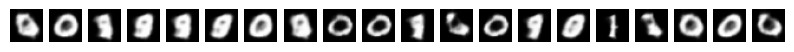

In [98]:
def generate_images(model, n=20):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dimension))
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images.numpy().reshape((n, 28, 28))
    
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(generated_images[i], cmap="gray")
        plt.axis("off")
    plt.show()
    
generate_images(variational_autoencoder)